In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [19]:
import torchvision

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),
                         (0.5, 0.5, 0.5))
])

# dataset = torchvision.datasets()
# Load CIFAR-10 dataset
dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    transform=transform,
    download=True
)

# DataLoader
batch_size = 128

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True
)

Image batch shape: torch.Size([128, 3, 32, 32])


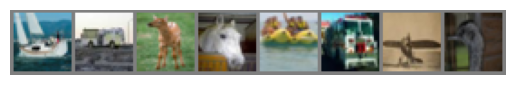

In [20]:
def imshow(img):
    img = img/2 + 0.5  # Convert [-1,1] → [0,1]
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()

# Get one batch
dataiter = iter(dataloader)
images, labels = next(dataiter)

print("Image batch shape:", images.shape)

# Show first 8 images
imshow(torchvision.utils.make_grid(images[:8]))

In [21]:
class Generator(nn.Module) :
    def __init__(self , nz = 100 , ngf = 64 , nc = 3) :
        super(Generator, self).__init__()

        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 2, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self,x) :
        return self.main(x)

netG = Generator().to(device)

noise = torch.randn(1, 100, 1, 1).to(device)
fake = netG(noise)
print(fake.shape)

torch.Size([1, 3, 32, 32])


In [22]:
class Discriminator(nn.Module):
    def __init__(self,nc=3,ndf=64) :
        super(Discriminator,self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self ,x):
        return self.main(x)

netD = Discriminator().to(device)
print(netD)

noice = torch.randn(1,3,32,32).to(device)
fake= netD(noice)
print(fake.shape)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)
torch.Size([1, 1, 1, 1])


In [23]:
def weights_init(m):
    classname = m.__class__.__name__

    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)

    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

netG.apply(weights_init)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)

In [24]:
criterion = nn.BCELoss()
real_label = 1.
fake_label = 0.

lr = 0.0002
beta1 = 0.5

optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
num_epochs = 50

fixed_noise = torch.randn(64, 100, 1, 1, device=device)

for i in range(num_epochs) :
    for j , data in enumerate(dataloader) :


        ############################
        # (1) Train Discriminator
        ############################
        netD.zero_grad()

        real_image = data[0].to(device)
        b_size = real_image.size(0)

        # Create real labels
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

        # Forward pass real images
        output = netD(real_image).view(-1)
        lossD_real = criterion(output, label)
        lossD_real.backward()


        # Generate fake images
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        fake = netG(noise).detach()   # VERY IMPORTANT

        label.fill_(fake_label)

        # Forward pass fake images
        output = netD(fake).view(-1)
        lossD_fake = criterion(output, label)

        lossD_fake.backward()

        # Total loss
        lossD = lossD_real + lossD_fake

        optimizerD.step()

        ############################
        # (2) Train Generator
        ############################

        netG.zero_grad()

        label.fill_(real_label)  # We want fake images to be classified as real!

        # Generate fake images AGAIN (no detach here!)
        noise = torch.randn(b_size, 100, 1, 1, device=device)
        fake = netG(noise)

        output = netD(fake).view(-1)

        lossG = criterion(output, label)

        lossG.backward()

        optimizerG.step()

    if 1:
        with torch.no_grad():
            fake_images = netG(fixed_noise).detach().cpu()

            grid = torchvision.utils.make_grid(fake_images, padding=2, normalize=True)

            plt.figure(figsize=(8,8))
            plt.imshow(grid.permute(1,2,0))
            plt.axis("off")
            plt.show()
    print(f"Epoch [{i}/{num_epochs}] "
        f"Batch {j}/{len(dataloader)} "
        f"Loss_D: {lossD.item():.4f} "
        f"Loss_G: {lossG.item():.4f}")